# Проведние A/B тестирования 
__________________

# Что такое A/B тестирование 

**A/B тестирование** — это  маркетинговый инструмент, с помощью которого можно повысить конверсию посадочных страниц или получить объективную информации о различных способах улучшения текущей версии продукта.

Например, мы изменили дизайн нашего сайта и хотим проверить стали ли пользователи совершать на нашем сайте больше целевых действий (например, покупок). Для этого нам и понадобится A/B тестирование.

**Идея A/B тестирования:** пользователи ресурса/продукта случайным образом делятся на сегменты:
- **контрольный сегмент "A"** - данному сегменту демонстрируется ресурс без изменений (например, старая версия сайта), на основе данных по этому сегменту мы будем оценивать эффект от вносимых изменений. 
- **сегмент "B"** - данному сегменту показываем измененную версию ресурса (например, новая версия сайта).

**Основные факторы А/B тестирования:**
- измерения в сегментах нужно проводить в один и тот же период времени. Нужно исключить влияние таких факторов как сезонность, день недели, время дня, проведение крупных рекламных кампаний и акций и т.д. То есть измерения в обоих сегментах проводятся в один и тот же отрезок времени. Понятно, сайт продающий новогодние игрушки для украшения ёлки будет пользоваться большей популярностью перед новым годом, чем в июне.
- нужно исключить влияние сегментов друг на друга, не допустить их смешивания, т.е. конкретный пользователь должен быть отнесен строго к одному сегменту.
- исключить влияние внутренних факторов. Такими факторами могут стать действия администраторов ресурса, разработчиков, технической поддержки и т.д.

В А/B тестировании **сегменты могут делиться 50/50, а могут и в других пропорциях**. Например, когда мы боимся, что изменения в ресурсе вызовут больше негатива у пользователей, имеет смысл сделать тестовый сегмент меньшей пропорции, а затем, в случае отсутсвия негативной реакции у пользователей, увеличить пропорцию тестового сегмента.  

# Загрузка библиотек

In [63]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from math import ceil

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


import datetime

from kaggle.api.kaggle_api_extended import KaggleApi

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.3f}'.format

sns.set_theme(style="whitegrid")

font = {'family' : 'serif',
        'weight' :'normal',
        'size'   : 13}

mpl.rc('font', **font)

# Загрузка датасета

In [2]:
!kaggle datasets list -s 'a\b'

ref                                                         title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/yufengsui/mobile-games-ab-testing                  Mobile Games: A/B Testing                      490KB  2019-07-22 08:37:03           1851         59  0.64705884       
datasets/ttahara/birdsong-resampled-train-audio-00          birdsong resampled train audio 00 (a ~ b)       12GB  2020-07-04 13:16:57           2085         64  0.64705884       
datasets/zhangluyuan/ab-testing                             A/B testing                                      4MB  2018-06-25 15:47:34           3927         51  0.1764706        
datasets/chebotinaa/fast-food-marketing-campaign-ab-test    Fast Food Marketing Campaign A\B Test        

In [3]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files("zhangluyuan/ab-testing", path='C:\\Users\\ЯцкийНА\\Portfolio\\A_B-testing', unzip=True)

In [4]:
df = pd.read_csv('ab_data.csv', parse_dates=[1])

# Описание датасета

На Kaggle отсутсвовало описание датасета. Поэтому опишем изходя из наименования признаков.

В датасете содержится 294 478 строк и 5 столбцов:

- **user_id:** ID пользователя.
- **timestamp:** временная метка
- **group:** наименование группы, к которой был отнесен пользователь - контрольная(control) или тестовая(treatment)
- **landing_page:** дизайн веб-страницы, которую видят пользователи (старый и новый дизайн)
- **converted:**  соверщено ли целевое действие или нет. Бинарный тип данных. 1 - совершено целевое действие, 0 - нет. 

Но все стобцы мы использовать не будем, для A/B тестирования понадобятся только столбцы **group и converted**.

In [5]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


# I Дизайн эксперимента 
__________

## 1. Постановка гипотезы

- **Нулевая гипотеза**: конверсии старой и новой версии равны.
- **Альтернативная гипотеза**: конверсии старой и новой версии отличаются.

$$H_0: \rho = \rho_0$$
$$H_1: \rho \neq \rho_0$$

где $\rho,\rho_0$ коэффициенты конверсии нового и старого дизайна нашего сайта.

**Уровень статистической значимости** установим **5%**, т.е $\alpha = 0.05$. **Уровень доверия - 95%**

Другими словами, мы хотим быть на 95% уверены, что коэффициент конверсии нового сайта отличается от коэффициента конверсии старого сайта, и мы не совершим ошибку первого рода. Если наша статистика попадет в критическую область, то мы отвергнем нулевую гипотезу.

## 2. Определение размера необходимой нам выборки 

В целом у нас не так много записей, поэтому можно провести анализ на всей генеральной совокупности, но для интереса проведем сэмплинг.

Размер статистической выборки зависит от следующих величин:
- **статистическая мощность**: обычно устанавоивается в районе 80-90%, ниже 80% не рекомендуется. Возмем **80%**.
- **статистическая значимость**: у нас она равна **0,05**.
- **величина эффекта**: в нашем случае это разница в конверсиях. Допустим, что нам достаточно разницы 2% между конверсиями старой и новой версии сайта. Также представим, что до того, как мы начали проведение нашего A/B тестирования, конверсия нашего сайта составляла **13%**, значит конверсия новой версии **15%** нас устроит. 

Рассчитаем размер необходимой нам выборки:

In [6]:
effect_size = sms.proportion_effectsize(0.13, 0.15)

sample_size = ceil(sms.NormalIndPower().solve_power(
    power=0.8,
    alpha=0.05,
    effect_size = effect_size
))

print(f'Нам необходимо {sample_size} наблюдений.')

Нам необходимо 4720 наблюдений.


# II Подготовка данных

### 1. Исследуем пропущенные значения

<AxesSubplot:>

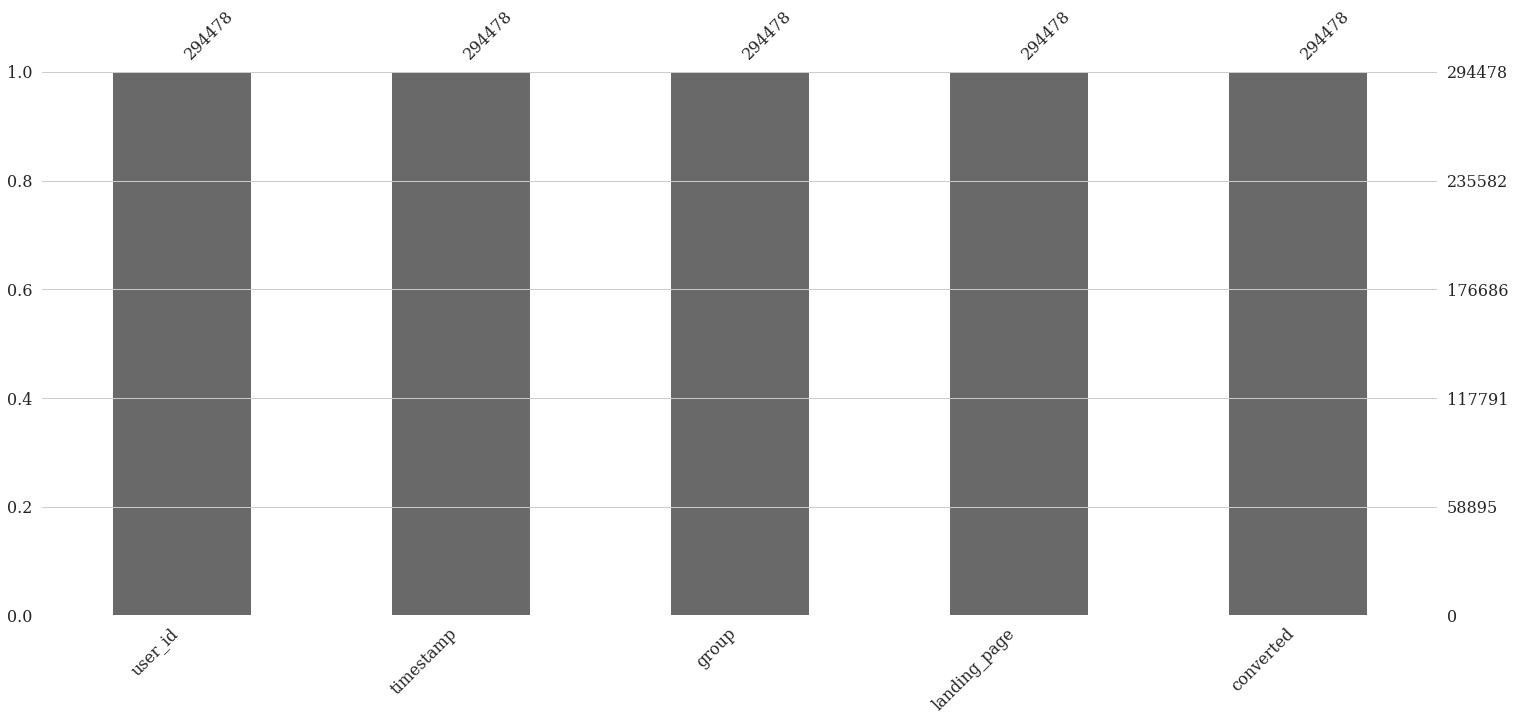

In [7]:
msno.bar(df)

<div class="alert alert-block alert-info">
<b>Вывод:</b> Замечательно, у нас нет пропущенных значений.
</div>

### 2. Изучим типы признаков

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


<div class="alert alert-block alert-info">
<b>Вывод:</b> Типы данных нас устраивают, менять их не будем.
</div>

### 3. Ищем пересечений по сегментам 

In [9]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


<div class="alert alert-block alert-info">
<b>Вывод:</b> У нас есть пересечения по сегментам, их нужно убрать, т.к. контрольная группа должна видеть только старую страницу, а тестовая только новую
</div>

### 4. Проверим нет ли у нас дублей среди пользователей

In [10]:
dubl_users = df['user_id'].duplicated().sum()

print(f'{dubl_users} пользователя появляются в наших данных несколько раз,\
что составляет {round(dubl_users/df.shape[0]*100, 2)}%')

3894 пользователя появляются в наших данных несколько раз,что составляет 1.32%


<div class="alert alert-block alert-info">
<b>Вывод:</b> 3894 пользователя появляются несклько раз, это составляется всего 1,32%. Это число довольно низкое, поэтому мы удалим их из нашего датасета, чтобы избежать повторной выборки одних и тех же пользователей.
</div>

### 5. Удаляем задублированных пользователей

In [11]:
df.drop_duplicates(subset=['user_id'], keep=False, inplace=True)

print(f'В нашем датасете осталось {df.shape[0]} значений')

В нашем датасете осталось 286690 значений


### 5. Еще раз проверяем пересечения по сегментам

In [12]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


<div class="alert alert-block alert-info">
<b>Вывод:</b> В нашем датасете осталось 286690 значений, пересечений по сегментам больше нет. Можно приступать к сэмплингу.
</div>

# III Сэмплинг 

Ранее мы установили оптимальный размер выборки - 4720 наблюдей. Теперь выберем в каждом нашем сегменте по 4720 наблюдений и соеденим в один датасет.

In [13]:
control_sample = df.loc[df['group'] == 'control'].sample(n=sample_size, random_state=22)
treatment_sample = df.loc[df['group'] == 'treatment'].sample(n=sample_size, random_state=22)

ab_test_df = pd.concat([control_sample, treatment_sample], axis=0).reset_index(drop=True)

ab_test_df

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


Посмотрим информацию о полученном датасете:

In [14]:
ab_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       9440 non-null   int64         
 1   timestamp     9440 non-null   datetime64[ns]
 2   group         9440 non-null   object        
 3   landing_page  9440 non-null   object        
 4   converted     9440 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 368.9+ KB


Убедимся, что у нас в каждом сегменте равное количество, как мы и задумывали:

In [15]:
ab_test_df['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

<div class="alert alert-block alert-info">
<b>Вывод:</b> Сэплинг прошел успешно, мы получили новый датасет из 9440 записей (по 4720 записей на каждый сегмент), можем приступать к рассчету конверсий.
</div>

# IV Рассчет конверсий 

По свойству среднего для бинарных данных, конверсия будет равна среднему значению. Рассчитаем базовые статистики:

In [16]:
basic_stats = ab_test_df\
              .groupby('group')['converted']\
              .agg(['count', 'mean', 'std', 'sem', 'var'])\
              .rename(columns={'mean':'conversation_rate'})

basic_stats

,count,conversation_rate,std,sem,var
group,,,,,
control,4720,0.123,0.329,0.005,0.108
treatment,4720,0.126,0.331,0.005,0.110


визуализируем конверсию старой и новой версии

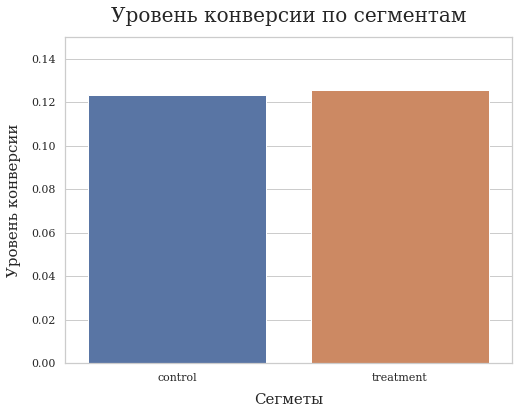

In [17]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test_df['group'], y=ab_test_df['converted'], ci=False)

plt.ylim(0, 0.15)
plt.title('Уровень конверсии по сегментам', pad=15, fontsize=20)
plt.xlabel('Сегметы', labelpad=10, fontsize=15)
plt.ylabel('Уровень конверсии', labelpad=10, fontsize=15);

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    
**Уровни конверсии:**
- контрольная группа - 12,3%
- тестовая группа - 12,6%
    
Значения конверсий для обоих групп близки, но не одинаковы. Необходимо проверить, является ли различие в конверсиях статистически значимым.
</div>

# V Тестирование гипотезы

У нас довольно большая выборка, мы можем использовать нормальное приближение для расчета нашего p-значения (z-критерия).

In [123]:
def calculate_statistics(control_group, treatment_group):

    n_con = control_group.count()
    n_treat = treatment_group.count()
    successes = [control_group.sum(), treatment_group.sum()]
    nobs = [n_con, n_treat]

    z_stat, p_val = proportions_ztest(successes, nobs=nobs)

    (ci_bottom_con, ci_bottom_treat), (ci_top_con, ci_top_treat) = \
    proportion_confint(successes, nobs=nobs, alpha=0.05)
    
    return {'z statistic': f'{z_stat:.3f}', 
            'p-value': f'{p_val:.3f}',
            'ci 95% for control group': f'{ci_bottom_con:.3f}, {ci_top_con:.3f}', 
            'ci 95% for treatment group': f'{ci_bottom_treat:.3f}, {ci_top_treat:.3f}'}

In [124]:
control_group = ab_test_df[ab_test_df['group'] == 'control']['converted']
treatment_group = ab_test_df[ab_test_df['group'] == 'treatment']['converted']

pprint.pprint(calculate_statistics(control_group, treatment_group), sort_dicts=False)

{'z statistic': '-0.343',
 'p-value': '0.732',
 'ci 95% for control group': '0.114, 0.133',
 'ci 95% for treatment group': '0.116, 0.135'}


# VI Вывод

Так как наше значение $p$ = 0,732 намного превышает пороговое значение $\alpha$ = 0,05, мы не можем отвергнуть нулевую гипотезу $H_0$, а это означает, что конверсия нашего нового дизайна существенно не отличается от конверсии старого дизайна.

Обрнатим внимание на доверительный интервал для экспериментальной группы ([0,116; 0,135] или 11,6–13,5%): 
- Он включает наше изначальное значение коэффициента конверсии 13%. 
- Он не включает наше целевое значение в 15 % (2 % роста, к которому мы стремились). 

Это означает, что скорее всего истинный коэффициент конверсии нового дизайна будет похож на наш изначальный уровень конверсии, а не на целевые 15%, на которые мы надеялись. Это еще одно доказательство того, что наш новый дизайн вряд ли приведет к увеличению конверсии по ставнению со старым дизайном.